In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA

from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor 
plt.style.use('seaborn')

In [5]:
data_df = pd.read_csv('Data\\processed.csv')

pre-process

In [6]:
# to_normalize = data_df[data_df.columns.difference(['KWH'])]

# kwh = data_df['KWH']
# data_df.drop(columns = 'KWH', inplace=True)

# df_to_normalize = Normalizer().fit_transform(to_normalize)
# df_to_normalize = pd.DataFrame(df_to_normalize)
# df_to_normalize.columns = data_df.columns

# data_df = pd.concat([df_to_normalize, kwh],axis = 1)
# print(data_df)

In [7]:
def plotVariance(X):
  pca = PCA(n_components=20)
  pca.fit(X)
  plt.figure()
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('Number of Components')
  plt.ylabel('Variance (%)')
  plt.title('Explained Variance')
  plt.show()

In [8]:
X = data_df[data_df.columns.difference(['KWH'])]
Y = data_df['KWH']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle = True, random_state = 42)

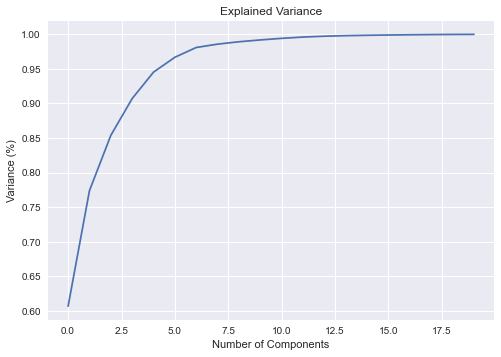

In [9]:
plotVariance(X_train)

In [10]:
PCA_train = PCA(n_components=10)
PCA_train.fit(X_train, Y_train)

dataPCA_train = PCA_train.transform(X_train)
dataPCA_test = PCA_train.transform(X_test)


In [11]:
rr = Ridge(
    random_state=42,
    solver = 'auto'

)
rf = RandomForestRegressor(
    oob_score = True, 
    random_state = 42,
)
sgd = SGDRegressor( 
    random_state=42,
    penalty='l1', 
)
ls = Lasso(
    random_state = 42 
)
estimators = [rr, rf, sgd, ls]

In [12]:
param_rr = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]} 
param_rf = {'n_estimators': [5, 50, 100, 200, 500], 'max_depth': [1, 5, 10, 15], 'min_samples_leaf': [1, 5, 10]}
param_sgd = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'loss': ['squared_epsilon_insensitive', 'huber'], 'learning_rate': ['optimal', 'adaptive']}
param_ls = {"selection":["cyclic", "random"], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
 
 
params = [param_rr, param_rf, param_sgd, param_ls]

In [13]:
def performingGridSearch(estimators, X_train, Y_train, X_test, Y_test, params):
  scores_train = []
  scores_test = []
 
  for index, estimator in enumerate(estimators):
    model = GridSearchCV(estimator, param_grid = params[index], cv = 3, n_jobs=-1, scoring='r2', verbose = 3)
    model.fit(X_train, Y_train)
    best_params = model.best_params_
    scores_train.append(model.score(X_train, Y_train))
 
    print("\n\n Model: {} \n\n Best params: {} ".format(estimator, best_params))
    scores_test.append(model.score(X_test, Y_test))
     
  return scores_train, scores_test

In [14]:
scores_train, scores_val = performingGridSearch(estimators, X_train, Y_train, X_test, Y_test, params)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


 Model: Ridge(random_state=42) 

 Best params: {'alpha': 1} 
Fitting 3 folds for each of 60 candidates, totalling 180 fits


In [ ]:
estimators_names = ['Ridge', 'RandomForest', 'SGDRegressor', 'Lasso']
models_scores = pd.DataFrame([estimators_names, scores_train, scores_val], columns = None, index = ['Estimators', 'Scores Train', 'Scores Val'])
print(models_scores)

models implementation

In [8]:
reg = LinearRegression().fit(dataPCA_train, Y_train)
print(reg.score(dataPCA_test, Y_test))
print(reg.score(dataPCA_train, Y_train))
print("\n\n")
lasso = Lasso(alpha=0.01)
lasso.fit(dataPCA_train, Y_train)
print(lasso.score(dataPCA_test, Y_test))
print(lasso.score(dataPCA_train, Y_train))

0.9719722092920277
0.9842402518015939



0.971972209301127
0.9842402518015939


High Correlation 

In [ ]:
print("\n\n Train summary: \n\n")
print("\n\n R2 Score: {} ".format(model.score(X_train, y_train)))
print("\n\n MSE Score: {} ".format(mean_squared_error(X_train, y_train)))
print("\n\n MAE Score: {} ".format(mean_absolute_error(X_train, y_train)))

print("\n\n Test summary: \n\n")
print("\n\n R2 Test Score: {} ".format(model.score(X_test, y_test)))
print("\n\n MSE Score: {} ".format(mean_squared_error(X_test, y_test)))
print("\n\n MAE Score: {} ".format(mean_absolute_error(X_test, y_test)))